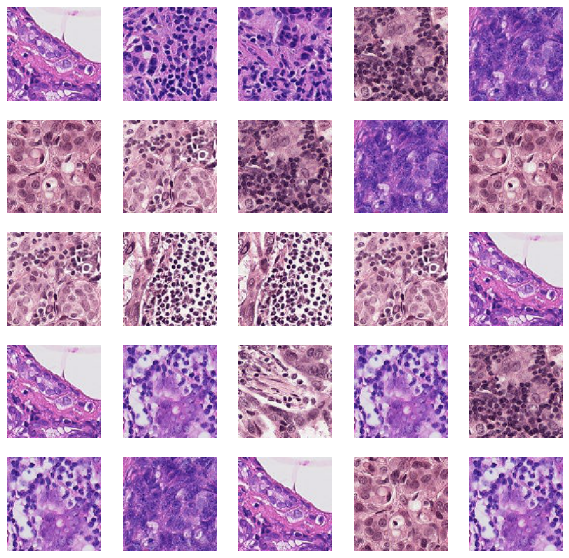

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from glob import glob
from keras.preprocessing.image import load_img, img_to_array

files = glob('C:/Users/20182413/Documents/Year 3 Quartile 3/BIA project/8p361-project-imaging-master/assignments/train+val/train/1/*.jpg')
#files[:10]

count =0
for file in files:
    if file[-5] == '1':
        count+=1
#print(count)

def show_img(files):
    plt.figure(figsize=(10, 10))
    ind = np.random.randint(0, len(files), 25)
    i = 0
    for loc in ind:
        plt.subplot(5, 5, i + 1)
        sample = load_img(files[loc], target_size=(150, 150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i += 1

show_img(files[:10])




In [2]:
import seaborn as sns

def load_balanced_data(files, size, start_index):
    half_size = int(size/2)
    count=0
    res = []
    y = []
    for file in tqdm(files[start_index:]):
        if (count!=half_size):
            if file[-5] == '1' and file.endswith(".png"):
                img = load_img(file, target_size = (75,75))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(1)
                count += 1
        else:
            break
                
    for file in tqdm(files[start_index:]):
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (75,75))
                pixels = img_to_array(img)
        else:
            break
                
    for file in tqdm(files[start_index:]):
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (75,75))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(0)
                count -= 1
        else:
            break
    return np.stack(res), y

In [3]:
#X_train2, y_train2 = load_balanced_data(files, 70000,0)

In [4]:
import os

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc


# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

# get the data generators
train_gen, val_gen = get_pcam_generators('C:/Users/20182413/Documents/Year 3 Quartile 3/BIA project/8p361-project-imaging-master/assignments/')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization,GlobalMaxPooling2D

In [6]:
pip install -U efficientnet

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-image in c:\users\20182413\anaconda3\envs\8p361\lib\site-packages (from efficientnet) (0.18.1)



In [7]:
import efficientnet.keras as efn

def def_model2(inp_shape = (75,75,3)):
    model = keras.models.Sequential([
            efn.EfficientNetB5(weights='imagenet',
                                include_top=False,
                                input_shape=inp_shape),
            GlobalMaxPooling2D(),
            Dense(1, activation = "sigmoid")          
        ])
    model.compile(optimizer = keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics = ['acc',keras.metrics.AUC(name='auc')])
    return model

model2 = def_model2()
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 3, 3, 2048)        28513520  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________


In [12]:
from keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(height_shift_range=0.2,
#                            width_shift_range=0.2,
#                            zoom_range=0.2,
#                            shear_range=0.2)
RESCALING_FACTOR = 1./255
# instantiate data generators
datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)


base_dir = 'C:/Users/20182413/Documents/Year 3 Quartile 3/BIA project/8p361-project-imaging-master/assignments/'
TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=64,
                                             class_mode='binary')
val_generator = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=64,
                                             class_mode='binary',
                                             shuffle=False)

callback = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',factor=0.25,patience=2, verbose=1,min_delta=0.0001,cooldown=0,min_lr=0.00001, mode='auto',
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [ ]:
history2 = model2.fit(train_generator, validation_data=val_generator, epochs = 1,
                     callbacks=[es,callback])
model2.save('model_EfficientNetB5.h5')

  71/2250 [..............................] - ETA: 2s - loss: 1.0181 - acc: 0.5469 - auc: 0.569 - ETA: 4:37:18 - loss: 1.0052 - acc: 0.5312 - auc: 0.52 - ETA: 5:48:05 - loss: 0.9313 - acc: 0.5938 - auc: 0.58 - ETA: 6:13:02 - loss: 0.9321 - acc: 0.5898 - auc: 0.60 - ETA: 6:29:25 - loss: 0.9130 - acc: 0.6062 - auc: 0.61 - ETA: 6:41:53 - loss: 0.9269 - acc: 0.6146 - auc: 0.63 - ETA: 6:49:24 - loss: 0.8906 - acc: 0.6362 - auc: 0.66 - ETA: 6:54:21 - loss: 0.9081 - acc: 0.6348 - auc: 0.66 - ETA: 7:26:01 - loss: 0.9503 - acc: 0.6337 - auc: 0.66 - ETA: 7:51:41 - loss: 0.9311 - acc: 0.6422 - auc: 0.67 - ETA: 8:00:17 - loss: 0.9217 - acc: 0.6491 - auc: 0.68 - ETA: 8:05:28 - loss: 0.8785 - acc: 0.6615 - auc: 0.70 - ETA: 8:05:15 - loss: 0.8813 - acc: 0.6695 - auc: 0.71 - ETA: 8:04:11 - loss: 0.8737 - acc: 0.6741 - auc: 0.72 - ETA: 8:03:26 - loss: 0.8557 - acc: 0.6781 - auc: 0.73 - ETA: 8:01:08 - loss: 0.8637 - acc: 0.6768 - auc: 0.73 - ETA: 8:01:39 - loss: 0.8570 - acc: 0.6811 - auc: 0.74 - ETA: 8:

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history2.history['acc'], label="train_acc")
plt.plot(history2.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label = "train_loss")
plt.plot(history2.history['val_loss'], label = "val_loss")
plt.legend()

In [ ]:
pred = model2.predict(x_test2)

res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)
        
from sklearn.metrics import classification_report, confusion_matrix
conf = confusion_matrix(y_test2, res)
sns.heatmap(conf,annot=True,fmt='0.2f',cmap='Oranges',xticklabels=['0','1'],yticklabels=['0','1'])
print(classification_report(y_test2, res))

from sklearn.metrics import roc_curve,roc_auc_score
pred_prob = pred

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test2, pred_prob[:], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test2))]
p_fpr, p_tpr, _ = roc_curve(y_test2, random_probs, pos_label=1)

# auc score
auc_score = roc_auc_score(y_test2, pred_prob[:])

print('AUC Score : ',auc_score)

In [ ]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='VGG16 Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
plt.figure(figsize= (20,15))
ind = np.random.randint(0, len(pred), 16)
i=0
for loc in ind:
    plt.subplot(4,4,i+1)
    plt.xlabel(None)
    plt.title(f"pred {res[loc]}, original {y_test2[loc]}")
        
    plt.imshow(x_test2[loc])
    i+=1